In [692]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import glob
import os
from datetime import datetime

sns.set(rc={'figure.figsize':(11,8)})
sns.set_context("paper", font_scale=1.6)   

<img src="assets/Province.png" width="550"/>

In [693]:
NOAAIndex = {
        1:24,
        2:25,
        3:5,
        4:6,
        5:27,
        6:23,
        7:26,
        8:7,
        9:11,
        10:13,
        11:14,
        12:15,
        13:16,
        14:17,
        15:18,
        16:19,
        17:21,
        18:22,
        19:8,
        20:9,
        21:10,
        22:1,
        23:3,
        24:2,
        25:4, 
        26:12, #Kiev
        27:20 #Sevastopol
}

In [621]:
def preprocess_raw_data(line):
    if '/' in line:        
        return ''    
    line = line.replace(' ', ',',2)    
    return (line + '\n')

In [635]:
def clear_dir(directory, index):
    for file in glob.glob(os.path.join(directory, "province-{}*.csv".format(index))):
        os.remove(file) #delete all previous data
    
def download_data(directory, index, minYear=1991, maxYear=2020):    
    with requests.Session() as sess:
        url = "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_provinceData.php?country=UKR&provinceID={}&year1={}&year2={}&type=Mean".format(NOAAIndex[index], minYear, maxYear)
        response = sess.get(url)
                
    path = os.path.join(directory, "province-{}.{}.csv".format(index, datetime.now().strftime("%d-%m-%Y_%H-%M")))        
            
    with open(path, 'w') as file:
        file.write("Year,Week,SMN,SMT,VCI,TCI,VHI\n")        
        for line in response.iter_lines(chunk_size=512, decode_unicode=True):                                            
            file.write(preprocess_raw_data(line)) #write line by line

In [636]:
for i in range(1,28):
    clear_dir("data", i)
    download_data("data", i)
    print("Province {} is downloaded".format(i))

Province 1 is downloaded
Province 2 is downloaded
Province 3 is downloaded
Province 4 is downloaded
Province 5 is downloaded
Province 6 is downloaded
Province 7 is downloaded
Province 8 is downloaded
Province 9 is downloaded
Province 10 is downloaded
Province 11 is downloaded
Province 12 is downloaded
Province 13 is downloaded
Province 14 is downloaded
Province 15 is downloaded
Province 16 is downloaded
Province 17 is downloaded
Province 18 is downloaded
Province 19 is downloaded
Province 20 is downloaded
Province 21 is downloaded
Province 22 is downloaded
Province 23 is downloaded
Province 24 is downloaded
Province 25 is downloaded
Province 26 is downloaded
Province 27 is downloaded


In [643]:
def load_all_data_to_pd(path):
    df = pd.DataFrame(columns=['Year','Week', 'SMN', 'SMT', 'VCI', 'TCI', 'VHI'])
    for file in glob.glob(os.path.join(path,"province-*.csv")):        
        temp = pd.read_csv(file, header=0)
        temp['Province'] = file.split('-')[1].split('.')[0] #specify province
        df = df.append(temp, ignore_index=True)
    
    #change types for memory saving
    df['Province'] = df['Province'].astype("int32")
    
    #generate datetime field
    dt = df['Year'].astype('str') + "-" + df['Week'].astype('str') + "-1"
    df['Period'] = pd.to_datetime(dt, format='%Y-%W-%w')
    df.drop(['Year', 'Week'], axis=1, inplace=True)    
    
    #change columns order
    old_columns = df.columns.tolist()
    columns = [] 
    columns.append(old_columns[-1])
    columns.append(old_columns[-2])
    columns.extend(old_columns[:-2])    
    df = df[columns]
    
    return df

In [644]:
df = load_all_data_to_pd("data")
df.sort_values(['Province','Period'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39879 entries, 13293 to 32493
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Period    39879 non-null  datetime64[ns]
 1   Province  39879 non-null  int32         
 2   SMN       39879 non-null  float64       
 3   SMT       39879 non-null  float64       
 4   VCI       39879 non-null  float64       
 5   TCI       39879 non-null  float64       
 6   VHI       39879 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int32(1)
memory usage: 2.3 MB


In [607]:
df.head(10)

,Period,Province,SMN,SMT,VCI,TCI,VHI
19201,1991-01-07,1,0.050,264.38,40.90,25.43,33.17
19202,1991-01-14,1,0.056,265.30,47.38,24.65,36.01
19203,1991-01-21,1,0.059,265.57,50.61,26.04,38.33
19204,1991-01-28,1,0.056,264.01,46.87,32.92,39.89
19205,1991-02-04,1,0.051,263.60,39.60,37.46,38.53
19206,1991-02-11,1,0.046,264.20,32.67,40.78,36.72
19207,1991-02-18,1,0.043,264.71,27.07,44.13,35.60
19208,1991-02-25,1,0.042,265.96,24.56,46.61,35.59
19209,1991-03-04,1,0.045,267.81,24.42,49.11,36.77
19210,1991-03-11,1,0.048,270.58,21.82,49.05,35.44


In [577]:
df.describe(include=['float'])

,SMN,SMT,VCI,TCI,VHI
count,39879.000000,39879.000000,39879.000000,39879.000000,39879.000000
mean,0.237638,283.064331,54.615915,41.404532,48.009796
std,0.144877,14.390377,20.415539,21.503946,11.419106
min,-0.005000,231.710000,0.000000,0.010000,5.520000
25%,0.100000,270.910000,39.515000,24.580000,40.540000
50%,0.221000,286.690000,55.820000,40.090000,47.410000
75%,0.368000,295.220000,70.890000,56.385000,55.190000
max,0.568000,309.950000,99.520000,100.000000,96.690000


In [605]:
def vhi_by_year_and_province(df, year, province):  
    return df[(df['Period'].dt.year == year) & (df['Province'] == province)].set_index('Period')['VHI']

def vhi_by_province(df, province):
    return df[df['Province'] == province].set_index('Period')['VHI']

In [645]:
vhi_by_province(df, 1)

Period
1991-01-07    33.17
1991-01-14    36.01
1991-01-21    38.33
1991-01-28    39.89
1991-02-04    38.53
              ...  
2020-02-03    45.19
2020-02-10    44.49
2020-02-17    43.65
2020-02-24    44.27
2020-03-02    47.83
Name: VHI, Length: 1477, dtype: float64

In [646]:
vhi_by_year_and_province(df, 2001, 1)

Period
2001-01-01    36.50
2001-01-08    39.49
2001-01-15    43.40
2001-01-22    42.84
2001-01-29    41.60
2001-02-05    41.90
2001-02-12    41.91
2001-02-19    41.87
2001-02-26    43.17
2001-03-05    45.12
2001-03-12    46.20
2001-03-19    48.84
2001-03-26    48.75
2001-04-02    49.02
2001-04-09    51.67
2001-04-16    53.22
2001-04-23    55.06
2001-04-30    60.34
2001-05-07    65.01
2001-05-14    67.69
2001-05-21    69.84
2001-05-28    71.31
2001-06-04    72.03
2001-06-11    71.94
2001-06-18    70.20
2001-06-25    68.09
2001-07-02    66.56
2001-07-09    63.59
2001-07-16    60.43
2001-07-23    55.68
2001-07-30    50.90
2001-08-06    47.38
2001-08-13    43.52
2001-08-20    41.63
2001-08-27    42.63
2001-09-03    44.37
2001-09-10    45.74
2001-09-17    45.04
2001-09-24    46.07
2001-10-01    48.23
2001-10-08    51.53
2001-10-15    56.89
2001-10-22    62.87
2001-10-29    64.44
2001-11-05    63.71
2001-11-12    62.88
2001-11-19    62.88
2001-11-26    62.86
2001-12-03    62.81
2001-12-10   

In [647]:
def years_by_vhi_range_by_province(df, province, minVHI, maxVHI, procentByYear):
    years = df[(df['Province'] == province)]['Period'].dt.year.unique()
    results = []
    for year in years:
        series = vhi_by_year_and_province(df, year, province)
        percent = series[(series >= minVHI) & (series <= maxVHI)].count() * 100 / series.count()
        if percent >= procentByYear:
            results.append(year)
    return results

In [648]:
years_by_vhi_range_by_province(df, 1, 0, 14, 7)

[2000]

In [649]:
years_by_vhi_range_by_province(df, 1, 15, 34, 7)

[1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1999,
 2000,
 2003,
 2007,
 2009,
 2012,
 2015,
 2016,
 2019]

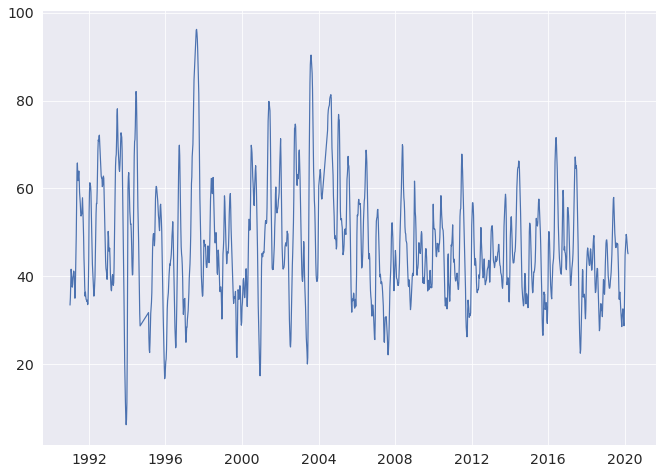

In [694]:
sns.lineplot(data=vhi_by_province(df,4));

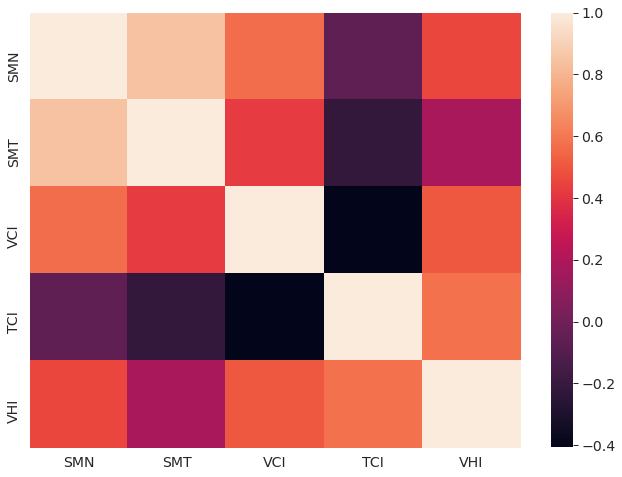

In [695]:
sns.heatmap(df.drop('Province', axis=1).corr());